### Question 1: Overall spending effect**
- Compare total spending per cycle by vehicle type: direct contributions, independent expenditures, 527 spending
- Fit interrupted time-series model with 2010 as intervention point
- **Primary metric:** Ratio of independent expenditures to total spending per cycle
- **Key differentiator (from proposal):** Analyze whether the "tilted playing field" is driven by traditional corporate PAC structures (which only saw ~14% increase) or the newer Super PAC/IE vehicles


In [27]:
# Load packages + connected to database

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn = sqlite3.connect('../data/citizens_united.db')


## 1. Load and aggregate spending by type

Query `partisan_spending_monthly` — the core derived table built by `02_clean.py`. Sum all spending by cycle and vehicle type (individual donations, direct PAC contributions, independent expenditures, 527 spending), inflation-adjusted to 2024 dollars. Exclude `unaligned` rows to keep only clearly partisan spending.

In [28]:
# Pull cycle and spending type totals for partisan spending, excluding non-party-directed spending
query = """
     SELECT Cycle, era, spending_type,
            SUM(total_amount_2024) AS total,
            SUM(n_transactions)    AS n_trans
     FROM partisan_spending_monthly
     WHERE partisan_direction != 'unaligned'
     GROUP BY Cycle, era, spending_type
     ORDER BY Cycle, spending_type
   """

# Read query into a dataframe
df = pd.read_sql(query, conn)

# pivot the dataframe to have spending types as columns and election year-cycles as rows
pivot = df.pivot(index='Cycle',
            columns='spending_type',
            values='total').fillna(0)

pivot


spending_type,527,individual,pac_direct,pac_independent
Cycle,,,,
2004,7.726287e+08,6.947881e+08,5.582795e+06,4.022877e+08
2008,3.114690e+08,1.042066e+09,4.701335e+06,3.299818e+08
2012,1.792782e+08,1.001564e+09,2.763514e+06,8.906821e+08
2020,5.687093e+08,9.583325e+08,1.828808e+06,1.386246e+09


## 2. Compute derived metrics

Add columns to `pivot`:
- `outside_spending` = `pac_independent` + `527` — the full pre/post-CU outside spending picture (527s were the pre-CU vehicle; IEs replaced them post-CU)
    - The combined total of all "outside" spending — money spent independently of candidates. 527 orgs were the pre-CU vehicle for unlimited spending; independent expenditures (IEs) became the dominant post-CU vehicle (Super PACs). Adding them together gives  a consistent "outside money" picture across all four cycles, rather than seeing IEs appear to start near zero in 2012 when really they just replaced 527s.
- `total` = sum of all four vehicle types per cycle
    - The grand total across all spending types per cycle (individual + pac_direct + pac_independent + 527). Used as the denominator for the ratios below.
- `ie_ratio` = share of total spending that is independent expenditures (the primary CU metric)
    - The share of all presidential spending that came from independent expenditures (Super PACs). This is the primary Citizens United metric — the fraction that was freed from contribution limits by the ruling.
- `outside_ratio` = share that is any form of outside spending (IE + 527)
    - The share that is any form of outside spending (IE + 527 combined). This is a more conservative check — it shows the total outside money footprint was actually fairly stable (27–40% across all cycles), meaning CU shifted the form of outside spending (527 → IE) more than it massively expanded outside spending as a fraction of the whole.

In [29]:
pivot['outside_spending'] = pivot['pac_independent'] + pivot['527']
pivot['total']            = pivot.sum(axis=1)
pivot['ie_ratio']         = pivot['pac_independent'] / pivot['total']
pivot['outside_ratio']    = pivot['outside_spending'] / pivot['total']

pivot

spending_type,527,individual,pac_direct,pac_independent,outside_spending,total,ie_ratio,outside_ratio
Cycle,,,,,,,,
2004,7.726287e+08,6.947881e+08,5.582795e+06,4.022877e+08,1.174916e+09,3.050204e+09,0.131889,0.385193
2008,3.114690e+08,1.042066e+09,4.701335e+06,3.299818e+08,6.414508e+08,2.329669e+09,0.141643,0.275340
2012,1.792782e+08,1.001564e+09,2.763514e+06,8.906821e+08,1.069960e+09,3.144249e+09,0.283273,0.340291
2020,5.687093e+08,9.583325e+08,1.828808e+06,1.386246e+09,1.954956e+09,4.870073e+09,0.284646,0.401422


## 3. Key metrics — IE vs. Direct PAC growth (2008 → 2012)

Compute the headline numbers from the literature:
- PAC independent expenditures grew ~594% from 2008 to 2012 (the CU effect, according to literature)
- PAC direct contributions grew only ~14% over the same period (unaffected by CU, subject to same limits)

- pac_direct (DI = 'D') — A PAC writes a check directly to a candidate's campaign. Subject to strict FEC contribution limits (e.g.    $5,000/candidate/election). CU did not change this. The candidate's campaign controls the money.                                                     
- pac_independent / IE (DI = 'I') — A PAC (specifically a Super PAC post-CU) spends money on its own — buying TV ads, mailers, etc. — to support or oppose a candidate, but cannot coordinate with the campaign. Post-CU, these are unlimited. This is what exploded after 2010.

The contrast between these two growth rates is the core empirical argument of the paper.

In [30]:
ie_2008 = pivot.loc['2008', 'pac_independent'] # get total IE in 2008
ie_2012 = pivot.loc['2012', 'pac_independent'] # get total IE in 2012
ie_growth_pct = (ie_2012 - ie_2008) / ie_2008 * 100  #calculate the percentage growth in IE spending from 2008 to 2012

print(f"IE spending grew by {ie_growth_pct:.2f}% from 2008 to 2012.")

direct_2008 = pivot.loc['2008', 'pac_direct'] # get total direct spending in 2008
direct_2012 = pivot.loc['2012', 'pac_direct'] # get total direct spending in 2012
direct_growth_pct = (direct_2012 - direct_2008) / direct_2008 * 100 #calculate the percentage growth in direct spending from 2008 to 2012
print(f"Direct spending fell by {direct_growth_pct:.2f}% from 2008 to 2012.")

IE spending grew by 169.92% from 2008 to 2012.
Direct spending fell by -41.22% from 2008 to 2012.


## 4. Print summary

Print the key growth figures and the full pivot table in readable form.

- IE Share — what fraction of all spending was independent expenditures. Doubled after CU (14% → 28%) and stayed there.
- Outside Share — IE + 527 combined as a fraction of all spending. This was lower in 2012 than 2004, which supports the substitution story: CU didn't massively expand outside spending overall, it just shifted it from 527s to IEs.

In [31]:

# Headline growth figures (2008 → 2012)
print("=== PAC Spending Growth: 2008 → 2012 ===")
print(f"  Independent expenditures: ${ie_2008/1e9:.2f}B → ${ie_2012/1e9:.2f}B  ({ie_growth_pct:+.1f}%)")
print(f"  Direct contributions:     ${direct_2008/1e6:.1f}M → ${direct_2012/1e6:.1f}M  ({direct_growth_pct:+.1f}%)")
print()

# Full pivot in readable form
print("=== Total Spending by Vehicle Type (2024 $B) ===")

display_cols = ['individual', 'pac_direct', 'pac_independent', '527', 'outside_spending', 'total']
fmt = pivot[display_cols].copy() / 1e9
fmt.columns = ['Individual', 'PAC Direct', 'PAC Indep. (IE)', '527', 'Outside Total', 'Grand Total']
print(fmt.to_string(float_format=lambda x: f"${x:.3f}B"))
print()

# --- Ratio summary ---
print("=== Outside Spending Ratios ===")
ratio_fmt = pivot[['ie_ratio', 'outside_ratio']].copy() * 100
ratio_fmt.columns = ['IE Share (%)', 'Outside Share (%)']
print(ratio_fmt.to_string(float_format=lambda x: f"{x:.1f}%"))


=== PAC Spending Growth: 2008 → 2012 ===
  Independent expenditures: $0.33B → $0.89B  (+169.9%)
  Direct contributions:     $4.7M → $2.8M  (-41.2%)

=== Total Spending by Vehicle Type (2024 $B) ===
       Individual  PAC Direct  PAC Indep. (IE)     527  Outside Total  Grand Total
Cycle                                                                             
2004      $0.695B     $0.006B          $0.402B $0.773B        $1.175B      $3.050B
2008      $1.042B     $0.005B          $0.330B $0.311B        $0.641B      $2.330B
2012      $1.002B     $0.003B          $0.891B $0.179B        $1.070B      $3.144B
2020      $0.958B     $0.002B          $1.386B $0.569B        $1.955B      $4.870B

=== Outside Spending Ratios ===
       IE Share (%)  Outside Share (%)
Cycle                                 
2004          13.2%              38.5%
2008          14.2%              27.5%
2012          28.3%              34.0%
2020          28.5%              40.1%


## 5. Figure 1 — Total spending by type (stacked bar)

One bar per cycle, stacked by vehicle type (bottom to top: individual → pac_direct → pac_independent → 527). A vertical dashed line between the 2008 and 2012 bars marks Citizens United (Jan 21, 2010). This is the primary Q1 figure showing both the growth in total spending and the shift in its composition.

Y-axis in 2024 $B. Include OpenSecrets attribution.

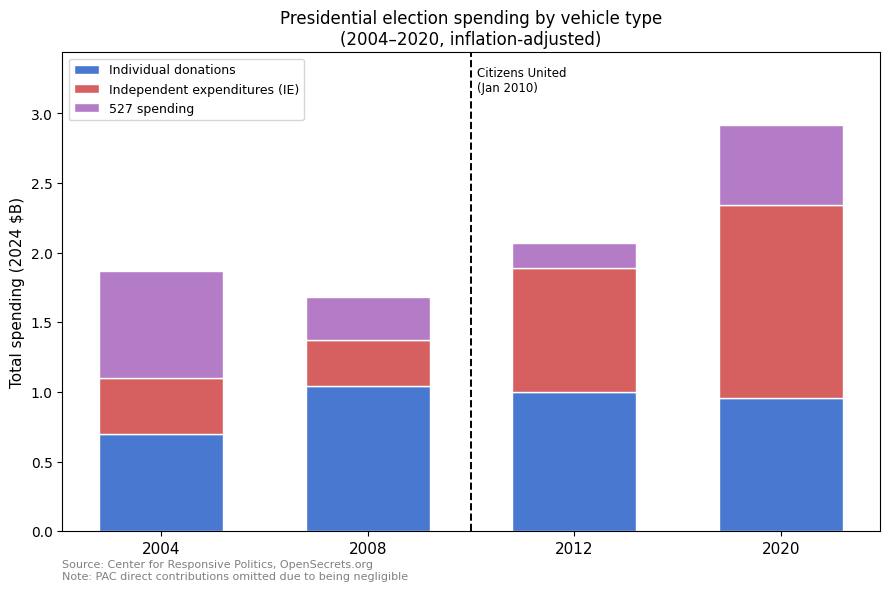

In [39]:
stack_cols   = ['individual', 'pac_independent', '527'] # cols to be included in chart
stack_labels = ['Individual donations', 'Independent expenditures (IE)', '527 spending'] # labels for the chart legend
stack_colors = ['#4878CF', '#D65F5F', '#B47CC7'] # colors for the stacked columns

cycles = pivot.index.tolist() # make list of cycles for x asixt
x = list(range(len(cycles))) # make numeric x values for plotting

fig, ax = plt.subplots(figsize=(9, 6)) # start a plot

bottoms = [0.0] * len(cycles) # set where the bottom of each bar starts (starts at 0 for all)
for col, label, color in zip(stack_cols, stack_labels, stack_colors): # for each column, label and color, plot a bar and update the bottom
    vals = pivot[col].values / 1e9 #get the values for this column and convert to billions
    ax.bar(x, vals, bottom=bottoms, label=label, color=color, width=0.6, edgecolor='white') # plot the stacked section for that col
    bottoms = [b + v for b, v in zip(bottoms, vals)] # update the bottom for thenext section

# Add Citizens United line
ax.axvline(x=1.5, color='black', linestyle='--', linewidth=1.4)
ax.text(1.53, 0.97, 'Citizens United\n(Jan 2010)',
        transform=ax.get_xaxis_transform(), fontsize=8.5, va='top')

# polish the graph with labels, title, legend, and source note
ax.set_xticks(x)
ax.set_xticklabels(cycles, fontsize=11)
ax.set_ylabel('Total spending (2024 $B)', fontsize=11)
ax.set_title('Presidential election spending by vehicle type\n(2004–2020, inflation-adjusted)', fontsize=12)
ax.legend(loc='upper left', fontsize=9)
ax.set_ylim(0, max(bottoms) * 1.18)

ax.text(0, -0.10, 'Source: Center for Responsive Politics, OpenSecrets.org\nNote: PAC direct contributions omitted due to being negligible',
        transform=ax.transAxes, fontsize=8, color='gray')
plt.tight_layout()


# show and save the figure
plt.savefig('../figures/q1_fig1_spending_by_type.pdf', bbox_inches='tight')
plt.show()


## 6. Figure 2 — IE share of total spending over time

Line chart with one point per cycle showing `ie_ratio` (pac_independent / total) as a percentage. The jump between 2008 and 2012 is the visual signature of Citizens United. Add the CU vertical line and label.

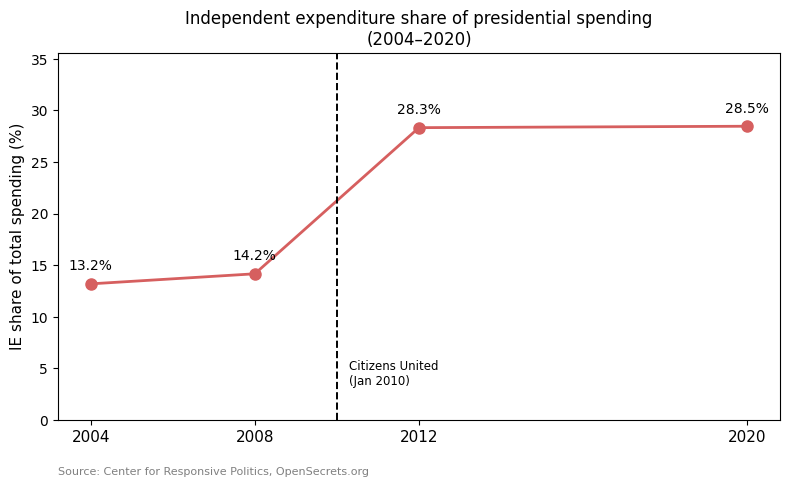

In [43]:
fig, ax = plt.subplots(figsize=(8, 5)) # start a new plot

cycles_int = [int(c) for c in pivot.index] # convert cycle labels to integers for plotting on x-axis
ie_pct = pivot['ie_ratio'] * 100 # convert the ratio to a percentage for graphical clarity

ax.plot(cycles_int, ie_pct, marker='o', linewidth=2, markersize=8, color='#D65F5F') # plot the line and markers

for cycle, val in zip(cycles_int, ie_pct): # for each cycle and value, add a label showing the percentage above the marker
    ax.annotate(f'{val:.1f}%', xy=(cycle, val), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=10)

# Citizens United line — between 2008 and 2012
ax.axvline(x=2010, color='black', linestyle='--', linewidth=1.4)
ax.text(2010.3, ax.get_ylim()[1] * 0.2, 'Citizens United\n(Jan 2010)',
        fontsize=8.5, va='top')

# polish the graph with labels, title, and source note
ax.set_xticks(cycles_int)
ax.set_xticklabels([str(c) for c in cycles_int], fontsize=11)
ax.set_ylabel('IE share of total spending (%)', fontsize=11)
ax.set_title('Independent expenditure share of presidential spending\n(2004–2020)', fontsize=12)
ax.set_ylim(0, max(ie_pct) * 1.25)

ax.text(0, -0.15, 'Source: Center for Responsive Politics, OpenSecrets.org',
        transform=ax.transAxes, fontsize=8, color='gray')

plt.tight_layout()

# show and save the figure
plt.savefig('../figures/q1_fig2_ie_share.pdf', bbox_inches='tight')
plt.show()


## 7. Figure 3 — Direct vs. Independent PAC spending (2008 → 2012)

Grouped bar chart with two groups (pac_direct, pac_independent), each showing the 2008 and 2012 values side by side. Annotate the bars with the growth percentages computed above. This is the "~14% vs. ~594%" comparison that is the key differentiator from prior work.

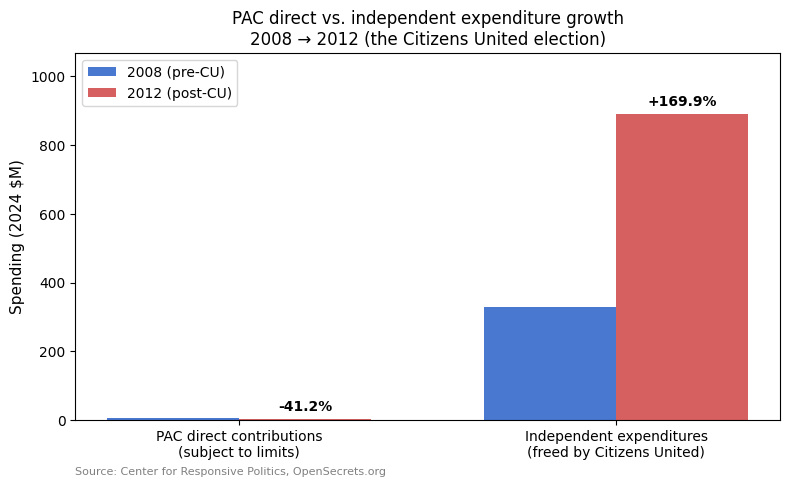

In [42]:
fig, ax = plt.subplots(figsize=(8, 5)) # start a new plot

bar_width = 0.35
x = [0, 1]  # two groups: pac_direct, pac_independent

# get the values for 2008 and convert to millions
vals_2008 = [pivot.loc['2008', 'pac_direct'] / 1e6,
             pivot.loc['2008', 'pac_independent'] / 1e6] 

# get the values for 2012 and convert to millions
vals_2012 = [pivot.loc['2012', 'pac_direct'] / 1e6,
             pivot.loc['2012', 'pac_independent'] / 1e6]
# plot the bars
bars_2008 = ax.bar([i - bar_width/2 for i in x], vals_2008, bar_width,
                   label='2008 (pre-CU)', color='#4878CF')
bars_2012 = ax.bar([i + bar_width/2 for i in x], vals_2012, bar_width,
                   label='2012 (post-CU)', color='#D65F5F')

# Annotate growth percentages above the 2012 bars. Shows that IE increased after CU and direct contributions fell
ax.annotate(f'{direct_growth_pct:+.1f}%',
            xy=(x[0] + bar_width/2, vals_2012[0]),
            xytext=(0, 6), textcoords='offset points', ha='center', fontsize=10, fontweight='bold')
ax.annotate(f'{ie_growth_pct:+.1f}%',
            xy=(x[1] + bar_width/2, vals_2012[1]),
            xytext=(0, 6), textcoords='offset points', ha='center', fontsize=10, fontweight='bold')

# polish the graph with labels, title, legend, and source note
ax.set_xticks(x)
ax.set_xticklabels(['PAC direct contributions\n(subject to limits)', 
                    'Independent expenditures\n(freed by Citizens United)'], fontsize=10)
ax.set_ylabel('Spending (2024 $M)', fontsize=11)
ax.set_title('PAC direct vs. independent expenditure growth\n2008 → 2012 (the Citizens United election)', fontsize=12)
ax.legend(fontsize=10)
ax.set_ylim(0, max(vals_2012) * 1.2)

ax.text(0, -0.15, 'Source: Center for Responsive Politics, OpenSecrets.org',
        transform=ax.transAxes, fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('../figures/q1_fig3_direct_vs_ie.pdf', bbox_inches='tight')
plt.show()


## 8. Save summary table

Save `pivot` (with all derived columns) to `output/tables/q1_spending_by_type.csv`. Create the output directories if they don't exist.

In [ ]:
import os

pivot.to_csv('../tables/q1_spending_by_type.csv')
print("Saved ../tables/q1_spending_by_type.csv")


Saved ../tables/q1_spending_by_type.csv
